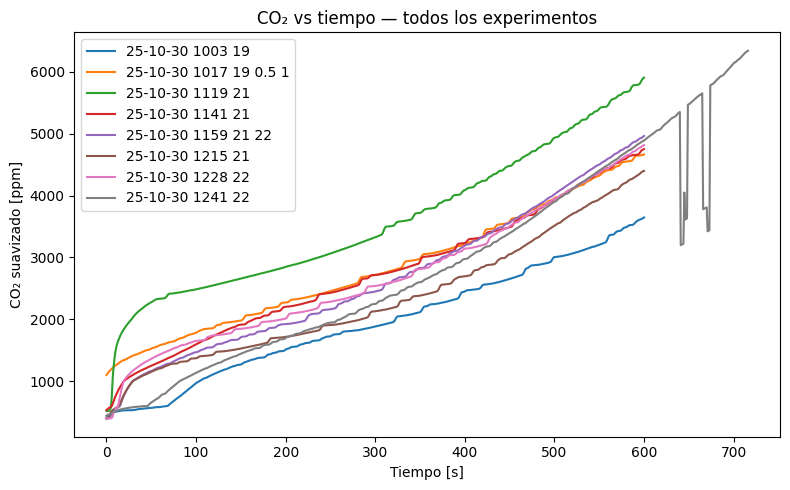

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

folder = Path("experimentos")
plt.figure(figsize=(8,5))

for file in sorted(folder.glob("*.txt")):
    df = pd.read_csv(
        file,
        sep=r"\s+", engine="python",
        usecols=["Time[s]", "CO2_smooth[ppm]"]
    ).dropna(subset=["Time[s]", "CO2_smooth[ppm]"])
    plt.plot(df["Time[s]"], df["CO2_smooth[ppm]"], label=file.stem)

plt.title("CO₂ vs tiempo — todos los experimentos")
plt.xlabel("Tiempo [s]")
plt.ylabel("CO₂ suavizado [ppm]")
plt.legend()
plt.tight_layout()
plt.show()


In [5]:
filtrado = datos.query("0 <= `Time[s]` <= 600")

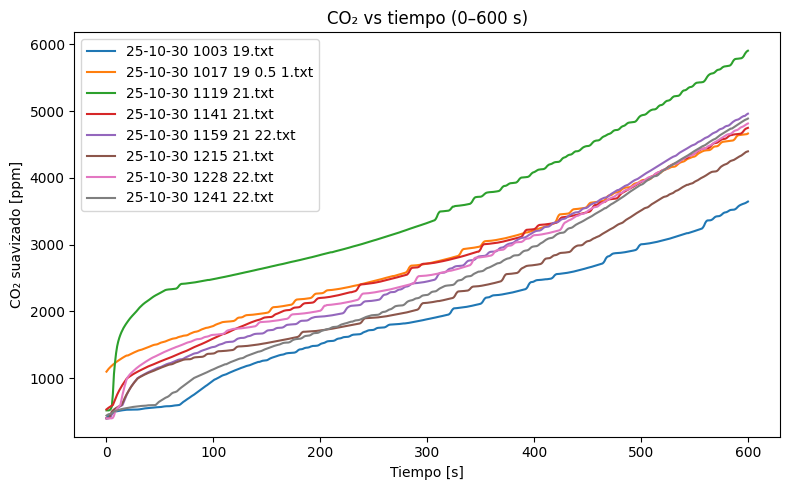

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

for nombre, grupo in filtrado.groupby("archivo"):
    plt.plot(grupo["Time[s]"], grupo["CO2_smooth[ppm]"], label=nombre)

plt.title("CO₂ vs tiempo (0–600 s)")
plt.xlabel("Tiempo [s]")
plt.ylabel("CO₂ suavizado [ppm]")
plt.legend()
plt.tight_layout()
plt.show()


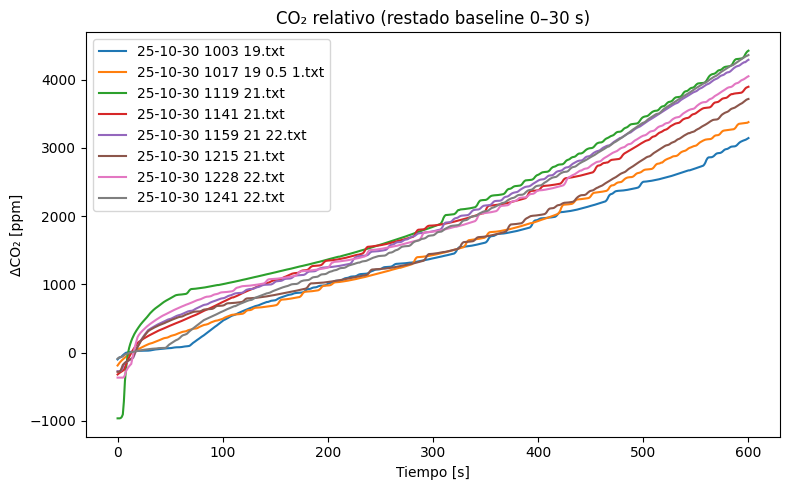

                   archivo  pendiente_ppm_s_60_300
      25-10-30 1241 22.txt                5.695733
      25-10-30 1141 21.txt                5.573017
      25-10-30 1003 19.txt                5.242666
   25-10-30 1159 21 22.txt                4.907877
25-10-30 1017 19 0.5 1.txt                4.633918
      25-10-30 1228 22.txt                4.285517
      25-10-30 1119 21.txt                3.952007
      25-10-30 1215 21.txt                3.511413


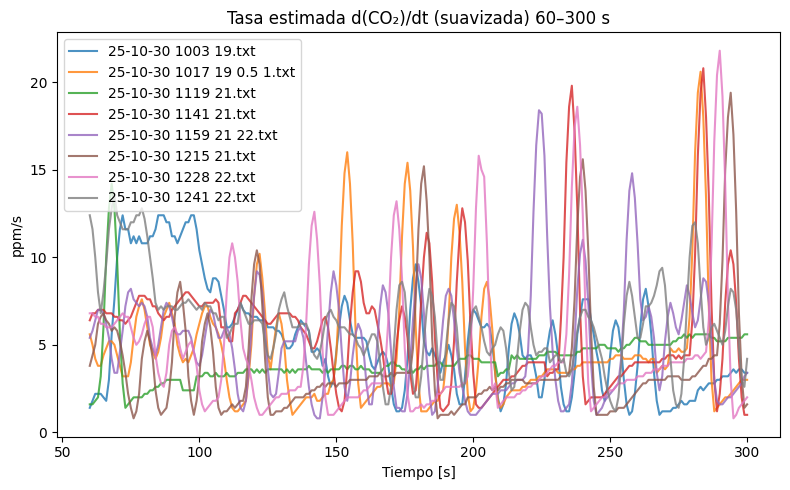

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Baseline por archivo (promedio de 0–30 s, más robusto que solo t=0)
base = (
    filtrado[filtrado["Time[s]"].between(0, 30)]
    .groupby("archivo")["CO2_smooth[ppm]"]
    .mean()
    .rename("baseline")
)
filtrado2 = filtrado.join(base, on="archivo")
filtrado2["CO2_rel[ppm]"] = filtrado2["CO2_smooth[ppm]"] - filtrado2["baseline"]

# Plot alineado (si todo era offset, ahora deberían verse parecidas)
plt.figure(figsize=(8,5))
for nombre, g in filtrado2.groupby("archivo"):
    plt.plot(g["Time[s]"], g["CO2_rel[ppm]"], label=nombre)
plt.title("CO₂ relativo (restado baseline 0–30 s)")
plt.xlabel("Tiempo [s]"); plt.ylabel("ΔCO₂ [ppm]")
plt.legend(); plt.tight_layout(); plt.show()

# 2) Pendiente (ppm/s) por archivo en ventana 60–300 s
def slope_linreg(t, y):
    # pendiente simple con polyfit
    m, b = np.polyfit(t, y, 1)
    return m

tabla = []
for nombre, g in filtrado2[filtrado2["Time[s]"].between(60, 300)].groupby("archivo"):
    t = g["Time[s]"].to_numpy()
    y = g["CO2_rel[ppm]"].to_numpy()
    m = slope_linreg(t, y)
    tabla.append({"archivo": nombre, "pendiente_ppm_s_60_300": m})

tabla = pd.DataFrame(tabla).sort_values("pendiente_ppm_s_60_300", ascending=False)
print(tabla.to_string(index=False))

# 3) (opcional) Derivada suavizada para ver tasas instantáneas
filtrado2 = filtrado2.sort_values(["archivo","Time[s]"])
filtrado2["dCO2_dt_est[ppm/s]"] = (
    filtrado2.groupby("archivo")["CO2_smooth[ppm]"]
    .apply(lambda s: s.rolling(5, center=True).mean().diff() / filtrado2.loc[s.index, "Time[s]"].diff())
    .values
)
plt.figure(figsize=(8,5))
for nombre, g in filtrado2[filtrado2["Time[s]"].between(60, 300)].groupby("archivo"):
    plt.plot(g["Time[s]"], g["dCO2_dt_est[ppm/s]"], label=nombre, alpha=0.8)
plt.title("Tasa estimada d(CO₂)/dt (suavizada) 60–300 s")
plt.xlabel("Tiempo [s]"); plt.ylabel("ppm/s"); plt.legend(); plt.tight_layout(); plt.show()


In [14]:
import pandas as pd
from pathlib import Path

folder = Path("experimentos")
dfs = []
for f in sorted(folder.glob("*.txt")):
    # toma columnas si existen; si no, las ignora
    df = pd.read_csv(
        f, sep=r"\s+", engine="python",
        usecols=lambda c: c in ["Time[s]","CO2_smooth[ppm]","stim_f[Hz]"]
    )
    if "stim_f[Hz]" not in df.columns:
        df["stim_f[Hz]"] = 0.0  # archivos sin evento → control
    df["archivo"] = f.name
    dfs.append(df)

datos = pd.concat(dfs, ignore_index=True)
# recorte 0–600 s
datos = datos.query("0 <= `Time[s]` <= 600").copy()


In [15]:
import numpy as np

# baseline por archivo (media 0–30 s)
base = (datos[datos["Time[s]"].between(0,30)]
        .groupby("archivo")["CO2_smooth[ppm]"].mean()
        .rename("baseline"))
filtrado2 = datos.join(base, on="archivo")
filtrado2["CO2_rel[ppm]"] = filtrado2["CO2_smooth[ppm]"] - filtrado2["baseline"]

# derivada suave (ppm/s)
def add_deriv(g):
    g = g.sort_values("Time[s]").copy()
    t = g["Time[s]"].to_numpy()
    y = g["CO2_rel[ppm]"].to_numpy()
    y_s = pd.Series(y).rolling(5, center=True, min_periods=1).mean().to_numpy()
    g["dCO2_dt_est[ppm/s]"] = np.gradient(y_s, t)
    return g

filtrado2 = filtrado2.groupby("archivo", group_keys=False).apply(add_deriv)


/tmp/ipykernel_22288/3440193845.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtrado2 = filtrado2.groupby("archivo", group_keys=False).apply(add_deriv)


In [17]:
# detectar t0 por archivo (NaN si no hay evento)
t0_por_archivo = (
    filtrado2[filtrado2["stim_f[Hz]"]>0]
    .groupby("archivo")["Time[s]"].min()
)

W_PRE, W_POST = 120, 120   # ventanas antes/después
IGNORAR_INICIO = 60        # evita warm-up

res = []
for nombre, g in filtrado2.groupby("archivo"):
    if nombre not in t0_por_archivo:    # no hubo evento → saltar (o tratar como control)
        continue
    t0 = float(t0_por_archivo.loc[nombre])

    pre  = g[(g["Time[s]"] >= max(t0-W_PRE, IGNORAR_INICIO)) & (g["Time[s]"] < t0)]
    post = g[(g["Time[s]"] >= t0) & (g["Time[s]"] <= min(t0+W_POST, 600))]
    if len(pre) < 5 or len(post) < 5:
        continue

    # pendientes lineales (ppm/s)
    m_pre,  b_pre  = np.polyfit(pre["Time[s]"],  pre["CO2_rel[ppm]"],  1)
    m_post, b_post = np.polyfit(post["Time[s]"], post["CO2_rel[ppm]"], 1)

    # cambio instantáneo de nivel y cambio de pendiente
    nivel_pre_t0  = m_pre*t0 + b_pre
    nivel_post_t0 = m_post*t0 + b_post
    delta_nivel = nivel_post_t0 - nivel_pre_t0
    delta_pend  = m_post - m_pre

    # cambio en tasa media (usando derivada suavizada)
    pre_mean  = pre["dCO2_dt_est[ppm/s]"].mean()
    post_mean = post["dCO2_dt_est[ppm/s]"].mean()

    res.append({
        "archivo": nombre, "t0_s": t0,
        "delta_pend_ppm_s": delta_pend,
        "delta_nivel_ppm":  delta_nivel,
        "delta_tasa_ppm_s": post_mean - pre_mean
    })

res = pd.DataFrame(res).sort_values("delta_pend_ppm_s", ascending=False)
print(res.to_string(index=False))


                archivo  t0_s  delta_pend_ppm_s  delta_nivel_ppm  delta_tasa_ppm_s
   25-10-30 1228 22.txt 157.0          0.195804       -31.453875         -0.128474
   25-10-30 1241 22.txt 194.0         -0.414430       -45.367460         -0.618898
   25-10-30 1141 21.txt 216.0         -0.515576       -34.745741         -0.645792
   25-10-30 1215 21.txt 101.0         -0.578171        -3.469816         -0.874320
   25-10-30 1119 21.txt  91.0         -0.659283       -26.452718         -0.514370
25-10-30 1159 21 22.txt 136.0         -0.974152       -24.068165         -0.887516


In [18]:
# ¿hay efecto consistente en el grupo?
rng = np.random.default_rng(0)

def perm_pvalue(deltas, M=10000):
    deltas = np.array(deltas, dtype=float)
    T_obs = deltas.mean()
    T_null = []
    for _ in range(M):
        signos = rng.choice([1,-1], size=deltas.size)
        T_null.append((signos*deltas).mean())
    T_null = np.abs(T_null)
    p = (np.sum(T_null >= abs(T_obs)) + 1) / (M + 1)
    return T_obs, p

for col in ["delta_pend_ppm_s", "delta_nivel_ppm", "delta_tasa_ppm_s"]:
    if col in res and len(res):
        T, p = perm_pvalue(res[col].to_numpy())
        print(f"{col}: media={T:.4g}  p≈{p:.4f}")


delta_pend_ppm_s: media=-0.491  p≈0.0621
delta_nivel_ppm: media=-27.59  p≈0.0284
delta_tasa_ppm_s: media=-0.6116  p≈0.0316


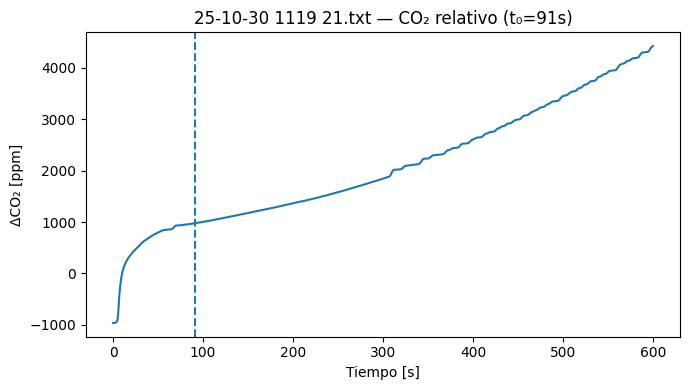

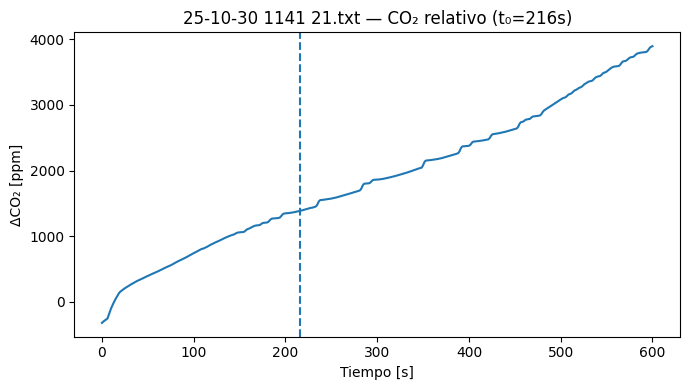

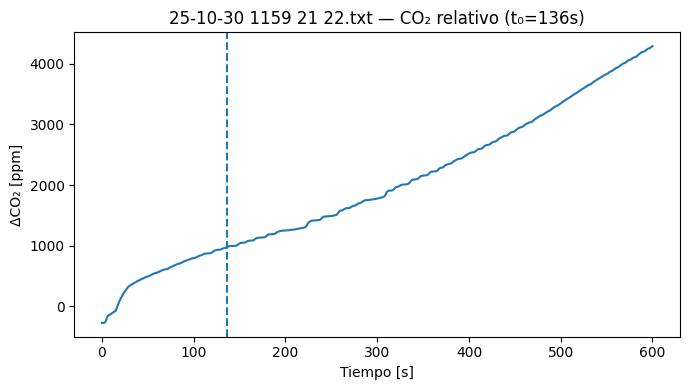

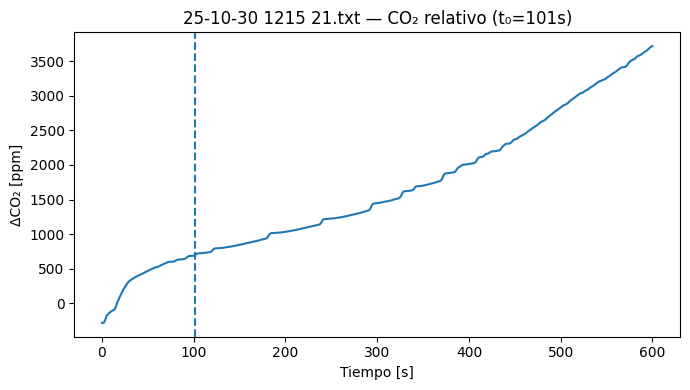

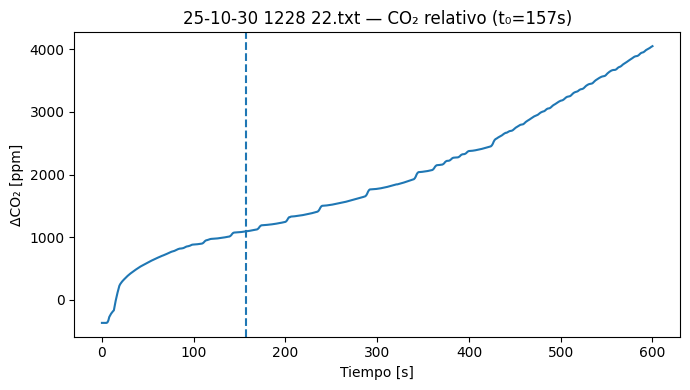

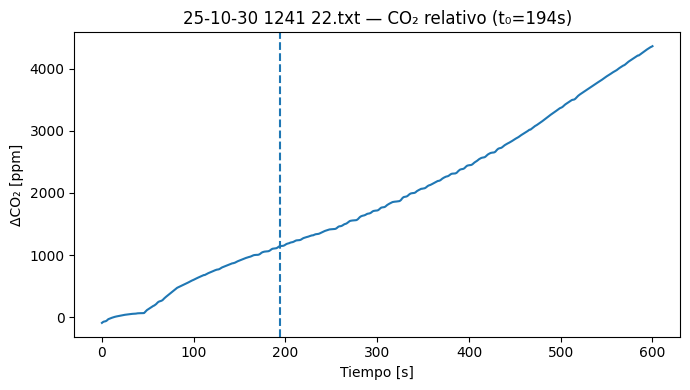

In [19]:
import matplotlib.pyplot as plt

for nombre, g in filtrado2.groupby("archivo"):
    if nombre not in t0_por_archivo: 
        continue
    t0 = float(t0_por_archivo.loc[nombre])
    plt.figure(figsize=(7,4))
    plt.plot(g["Time[s]"], g["CO2_rel[ppm]"])
    plt.axvline(t0, ls="--")
    plt.title(f"{nombre} — CO₂ relativo (t₀={t0:.0f}s)")
    plt.xlabel("Tiempo [s]"); plt.ylabel("ΔCO₂ [ppm]")
    plt.tight_layout(); plt.show()


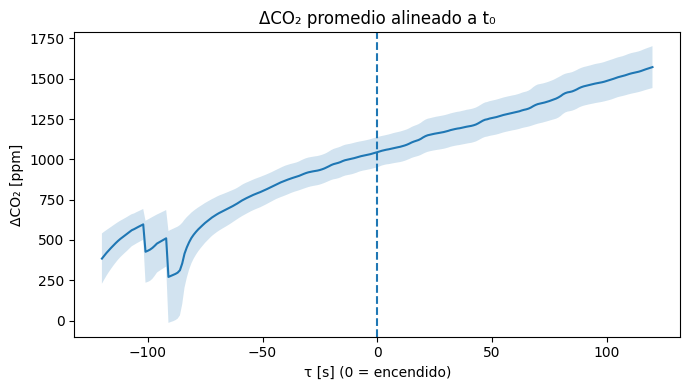

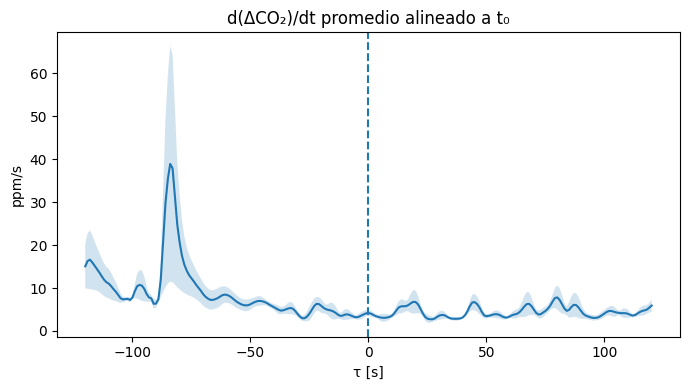

In [20]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# τ = tiempo relativo al evento
def add_tau(g, t0):
    g = g.copy()
    g["tau[s]"] = g["Time[s]"] - t0
    return g

win = 120  # segundos antes/después
lista = []
for nombre, g in filtrado2.groupby("archivo"):
    t0 = t0_por_archivo.get(nombre, np.nan)
    if np.isnan(t0): 
        continue
    gg = add_tau(g, t0)
    gg = gg[(gg["tau[s]"]>=-win) & (gg["tau[s]"]<=win)]
    lista.append(gg)

evt = pd.concat(lista, ignore_index=True)

# re-muestrea a grilla entera de segundos para promediar
grid = pd.DataFrame({"tau[s]": np.arange(-win, win+1)})
curvas = []
for nombre, g in evt.groupby("archivo"):
    curvas.append(
        grid.merge(g[["tau[s]","CO2_rel[ppm]","dCO2_dt_est[ppm/s]"]]
                   .groupby("tau[s]").mean().reset_index(),
                   on="tau[s]", how="left")
            .assign(archivo=nombre)
    )
evt2 = pd.concat(curvas, ignore_index=True)

mean_co2 = evt2.groupby("tau[s]")["CO2_rel[ppm]"].mean()
sem_co2  = evt2.groupby("tau[s]")["CO2_rel[ppm]"].sem()
mean_d   = evt2.groupby("tau[s]")["dCO2_dt_est[ppm/s]"].mean()
sem_d    = evt2.groupby("tau[s]")["dCO2_dt_est[ppm/s]"].sem()

plt.figure(figsize=(7,4))
plt.plot(mean_co2.index, mean_co2.values)
plt.fill_between(mean_co2.index, mean_co2-sem_co2, mean_co2+sem_co2, alpha=0.2)
plt.axvline(0, ls="--")
plt.title("ΔCO₂ promedio alineado a t₀")
plt.xlabel("τ [s] (0 = encendido)"); plt.ylabel("ΔCO₂ [ppm]")
plt.tight_layout(); plt.show()

plt.figure(figsize=(7,4))
plt.plot(mean_d.index, mean_d.values)
plt.fill_between(mean_d.index, mean_d-sem_d, mean_d+sem_d, alpha=0.2)
plt.axvline(0, ls="--")
plt.title("d(ΔCO₂)/dt promedio alineado a t₀")
plt.xlabel("τ [s]"); plt.ylabel("ppm/s")
plt.tight_layout(); plt.show()


/tmp/ipykernel_22288/3341364096.py:51: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("archivo", group_keys=False).apply(add_deriv)



== Resumen por archivo ==
             archivo    cond  t0_s  delta_pend_ppm_s  delta_nivel_ppm  delta_tasa_ppm_s
25-10-30 1003 19.txt control 194.0         -2.719566       -35.931963         -3.096067
25-10-30 1141 21.txt    stim 216.0         -0.515576       -34.745741         -0.645792
25-10-30 1241 22.txt    stim 194.0         -0.414430       -45.367460         -0.618898


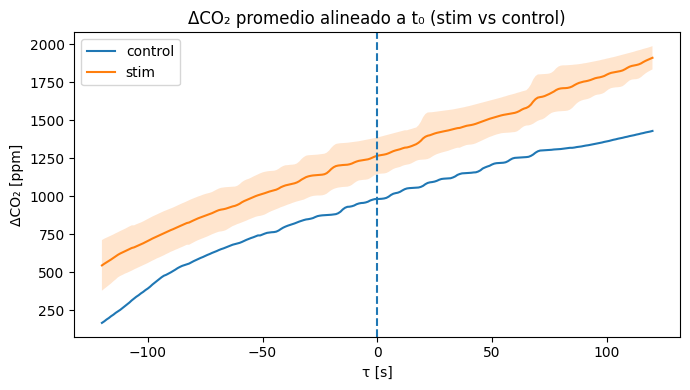

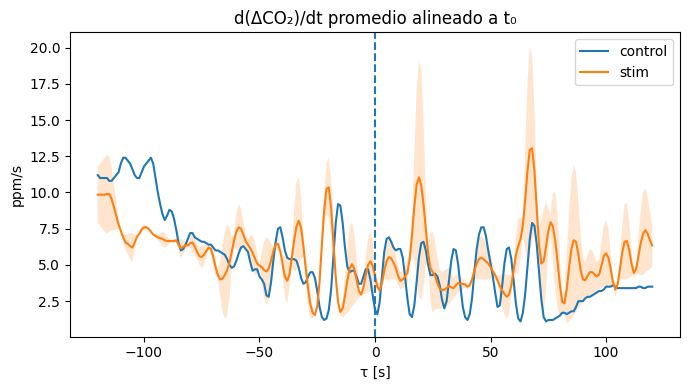

/tmp/ipykernel_22288/3341364096.py:164: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=["control","stim"])


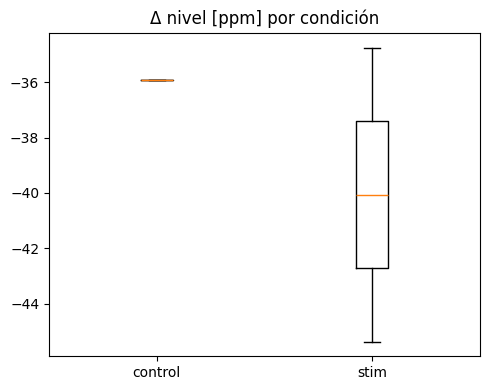

/tmp/ipykernel_22288/3341364096.py:164: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=["control","stim"])


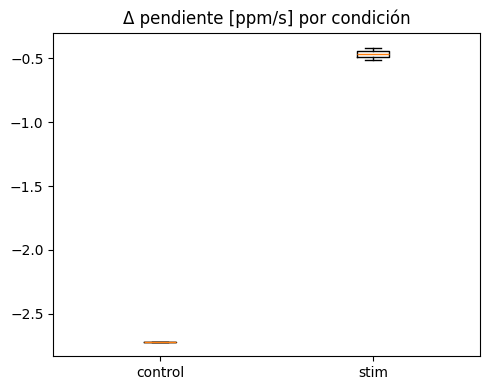

/tmp/ipykernel_22288/3341364096.py:164: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=["control","stim"])


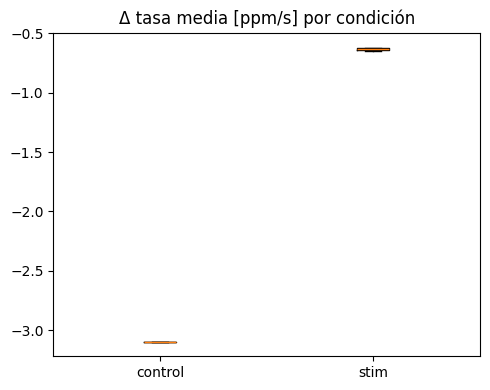


== Tests por condición (control vs stim): diferencia de medias (control - stim) ==
  delta_nivel_ppm: muestras insuficientes
 delta_pend_ppm_s: muestras insuficientes
 delta_tasa_ppm_s: muestras insuficientes


In [21]:
# ===================== PARÁMETROS =====================
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

FOLDER_STIM = Path("experimentos")              # con columna stim_f[Hz]
FOLDER_CTRL = Path("experimentos") / "de 1000"  # controles
T_MIN, T_MAX = 0, 600
BASELINE_WIN = (0, 30)      # para alinear
W_PRE, W_POST = 120, 120    # ventanas para métricas
IGNORAR_INICIO = 60         # evita warm-up al estimar efectos

# ===================== LECTURA =====================
def leer_carpeta(carpeta, cond):
    dfs = []
    for f in sorted(carpeta.glob("*.txt")):
        df = pd.read_csv(
            f, sep=r"\s+", engine="python",
            usecols=lambda c: c in ["Time[s]","CO2_smooth[ppm]","stim_f[Hz]"]
        )
        if "stim_f[Hz]" not in df.columns:
            df["stim_f[Hz]"] = 0.0
        df["archivo"] = f.name
        df["cond"] = cond
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

stim = leer_carpeta(FOLDER_STIM, "stim")
ctrl = leer_carpeta(FOLDER_CTRL, "control")

datos = pd.concat([stim, ctrl], ignore_index=True)
datos = datos.query(f"`Time[s]` >= {T_MIN} and `Time[s]` <= {T_MAX}").copy()

# ===================== BASELINE & DERIVADA =====================
# baseline por archivo (media 0–30 s)
base = (datos[datos["Time[s]"].between(*BASELINE_WIN)]
        .groupby("archivo")["CO2_smooth[ppm]"].mean()
        .rename("baseline"))
df = datos.join(base, on="archivo")
df["CO2_rel[ppm]"] = df["CO2_smooth[ppm]"] - df["baseline"]

# derivada suave por archivo (ppm/s)
def add_deriv(g):
    g = g.sort_values("Time[s]").copy()
    t = g["Time[s]"].to_numpy()
    y = g["CO2_rel[ppm]"].to_numpy()
    y_s = pd.Series(y).rolling(5, center=True, min_periods=1).mean().to_numpy()
    g["dCO2_dt_est[ppm/s]"] = np.gradient(y_s, t)
    return g

df = df.groupby("archivo", group_keys=False).apply(add_deriv)

# ===================== t0 REAL (stim) y PSEUDO-t0 (control) =====================
# t0 real: primer tiempo con stim_f>0
t0_stim = (df[(df["cond"]=="stim") & (df["stim_f[Hz]"]>0)]
           .groupby("archivo")["Time[s]"].min())

# para controles: emparejamos distribución de t0 de 'stim'
t0_vals = t0_stim.dropna().to_numpy()
if t0_vals.size == 0:  # fallback: mitad del tramo
    t0_vals = np.array([(T_MIN+T_MAX)/2])

rng = np.random.default_rng(42)
t0_ctrl_map = {
    name: float(rng.choice(t0_vals))
    for name in df.loc[df["cond"]=="control","archivo"].unique()
}

def get_t0(row):
    if row["cond"] == "stim":
        return float(t0_stim.get(row["archivo"], np.nan))
    else:
        return t0_ctrl_map[row["archivo"]]

df["t0_s"] = df.apply(get_t0, axis=1)

# quitamos archivos sin t0 válido o con ventanas insuficientes
validos = []
for name, g in df.groupby("archivo"):
    t0 = g["t0_s"].iloc[0]
    if np.isnan(t0): 
        continue
    if (t0 - W_PRE) < (T_MIN + IGNORAR_INICIO) or (t0 + W_POST) > T_MAX:
        continue
    validos.append(name)
df = df[df["archivo"].isin(validos)].copy()

# ===================== MÉTRICAS POR ARCHIVO =====================
res = []
for (name, cond), g in df.groupby(["archivo","cond"]):
    t0 = g["t0_s"].iloc[0]
    pre  = g[(g["Time[s]"] >= max(t0-W_PRE, IGNORAR_INICIO)) & (g["Time[s]"] < t0)]
    post = g[(g["Time[s]"] >= t0) & (g["Time[s]"] <= t0+W_POST)]
    if len(pre) < 5 or len(post) < 5:
        continue
    # pendientes lineales
    m_pre,  b_pre  = np.polyfit(pre["Time[s]"],  pre["CO2_rel[ppm]"],  1)
    m_post, b_post = np.polyfit(post["Time[s]"], post["CO2_rel[ppm]"], 1)
    nivel_pre_t0  = m_pre*t0 + b_pre
    nivel_post_t0 = m_post*t0 + b_post

    res.append({
        "archivo": name, "cond": cond, "t0_s": t0,
        "delta_pend_ppm_s": m_post - m_pre,
        "delta_nivel_ppm":  nivel_post_t0 - nivel_pre_t0,
        "delta_tasa_ppm_s": post["dCO2_dt_est[ppm/s]"].mean() - pre["dCO2_dt_est[ppm/s]"].mean(),
    })
res = pd.DataFrame(res)

print("\n== Resumen por archivo ==")
print(res.sort_values(["cond","delta_tasa_ppm_s"]).to_string(index=False))

# ===================== VISUALES =====================
# 1) Curvas promedio alineadas por condición (ΔCO2 y derivada)
def alineado_por_cond(df, win=120):
    lst=[]
    for (name, cond), g in df.groupby(["archivo","cond"]):
        t0 = g["t0_s"].iloc[0]
        gg = g.copy()
        gg["tau[s]"] = gg["Time[s]"] - t0
        gg = gg[(gg["tau[s]"]>=-win) & (gg["tau[s]"]<=win)]
        lst.append(gg)
    evt = pd.concat(lst, ignore_index=True)
    grid = pd.DataFrame({"tau[s]": np.arange(-win, win+1)})
    curves=[]
    for cond, g in evt.groupby("cond"):
        tmp=[]
        for name, gg in g.groupby("archivo"):
            tmp.append(
                grid.merge(gg[["tau[s]","CO2_rel[ppm]","dCO2_dt_est[ppm/s]"]]
                           .groupby("tau[s]").mean().reset_index(),
                           on="tau[s]", how="left")
                    .assign(cond=cond, archivo=name)
            )
        curves.append(pd.concat(tmp, ignore_index=True))
    return pd.concat(curves, ignore_index=True)

evt2 = alineado_por_cond(df, win=min(W_PRE, W_POST))

def plot_mean_sem(evt2, col, title, ylabel):
    mean = evt2.groupby(["cond","tau[s]"])[col].mean().unstack(0)
    sem  = evt2.groupby(["cond","tau[s]"])[col].sem().unstack(0)

    plt.figure(figsize=(7,4))
    for cond in mean.columns:
        plt.plot(mean.index, mean[cond], label=cond)
        lo, hi = mean[cond]-sem[cond], mean[cond]+sem[cond]
        plt.fill_between(mean.index, lo, hi, alpha=0.2)
    plt.axvline(0, ls="--")
    plt.title(title); plt.xlabel("τ [s]"); plt.ylabel(ylabel); plt.legend(); plt.tight_layout(); plt.show()

plot_mean_sem(evt2, "CO2_rel[ppm]", "ΔCO₂ promedio alineado a t₀ (stim vs control)", "ΔCO₂ [ppm]")
plot_mean_sem(evt2, "dCO2_dt_est[ppm/s]", "d(ΔCO₂)/dt promedio alineado a t₀", "ppm/s")

# 2) Boxplots de métricas por condición
for col, lab in [
    ("delta_nivel_ppm", "Δ nivel [ppm]"),
    ("delta_pend_ppm_s","Δ pendiente [ppm/s]"),
    ("delta_tasa_ppm_s","Δ tasa media [ppm/s]"),
]:
    plt.figure(figsize=(5,4))
    data = [res.loc[res["cond"]=="control", col].dropna(),
            res.loc[res["cond"]=="stim", col].dropna()]
    plt.boxplot(data, labels=["control","stim"])
    plt.title(f"{lab} por condición"); plt.tight_layout(); plt.show()

# ===================== TESTS (perm. 2 muestras) =====================
rng = np.random.default_rng(123)

def perm_2sample(x, y, M=10000):
    x = np.asarray(x, float); y = np.asarray(y, float)
    pooled = np.concatenate([x, y])
    nx = len(x)
    T_obs = x.mean() - y.mean()
    cnt = 0
    for _ in range(M):
        rng.shuffle(pooled)
        T = pooled[:nx].mean() - pooled[nx:].mean()
        if abs(T) >= abs(T_obs): cnt += 1
    p = (cnt + 1) / (M + 1)
    return T_obs, p

print("\n== Tests por condición (control vs stim): diferencia de medias (control - stim) ==")
for col in ["delta_nivel_ppm","delta_pend_ppm_s","delta_tasa_ppm_s"]:
    x = res.loc[res["cond"]=="control", col].dropna()
    y = res.loc[res["cond"]=="stim",    col].dropna()
    if len(x)>1 and len(y)>1:
        T, p = perm_2sample(x, y)
        print(f"{col:>17}: Δmedias={T:.4g}   p≈{p:.4f}   (n_ctrl={len(x)}, n_stim={len(y)})")
    else:
        print(f"{col:>17}: muestras insuficientes")
